## OCR Training (TrOCR) — Smoke Test

**What this does**
1. Index line PNGs → create/merge `data/ground_truth_lines.csv` (no images are modified).
2. Label **one** line (or batch label several).
3. Train **one epoch on CPU** using the single labeled row (MPS/GPU disabled to avoid OOM).
4. Inference on that line + compute **WER/CER**, write `runs/trocr_one_image_cpu/predictions.csv`.


In [23]:


import os, glob, pandas as pd, numpy as np
from pathlib import Path
from PIL import Image
import torch
from datasets import Dataset
from transformers import (
    TrOCRProcessor, VisionEncoderDecoderModel,
    Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator,
)


LINES_DIR = "image_splits/training_set_splits/segmented_lines_per_image" 
CSV_PATH  = "data/ground_truth_lines.csv"
RUN_ONE   = "runs/trocr_one_image_cpu"
MODEL_ONE = "models/trocr_one_image_cpu"
Path(CSV_PATH).parent.mkdir(parents=True, exist_ok=True)
os.makedirs(RUN_ONE, exist_ok=True); os.makedirs(MODEL_ONE, exist_ok=True)


def _cer(ref, hyp):
    m, n = len(ref), len(hyp)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        ri = ref[i-1]
        for j in range(1, n+1):
            cost = 0 if ri == hyp[j-1] else 1
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
    return dp[m][n] / max(1, m)

def _wer(ref, hyp):
    r, h = ref.lower().split(), hyp.lower().split()
    m, n = len(r), len(h)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        ri = r[i-1]
        for j in range(1, n+1):
            cost = 0 if ri == h[j-1] else 1
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
    return dp[m][n] / max(1, m)

print("Config OK. CWD:", os.getcwd())


Config OK. CWD: /Users/gabvinttongol/Desktop/Thesis/ocr-models


creates or updates the `ground_truth_lines.csv`


In [24]:

# Collect PNGs recursively
pngs = sorted(glob.glob(f"{LINES_DIR}/**/*.png", recursive=True))
assert len(pngs) > 0, f"No PNGs found under {LINES_DIR}. Check your paths."

df_new = pd.DataFrame({
    "image_path": [p.replace("\\","/") for p in pngs],
    "transcription": [""]*len(pngs)
})

# Merge with existing CSV (keep old labels)
if Path(CSV_PATH).exists():
    df_old = pd.read_csv(CSV_PATH)
    if "image_path" not in df_old.columns:
        raise ValueError(f"{CSV_PATH} missing 'image_path' column")
    if "transcription" not in df_old.columns:
        df_old["transcription"] = ""
    df_old["image_path"] = df_old["image_path"].astype(str).str.replace("\\","/", regex=False)
    merged = pd.merge(df_new, df_old, on="image_path", how="outer", suffixes=("_new","_old"))
    merged["transcription"] = merged["transcription_old"].fillna("").where(
        merged["transcription_old"].fillna("") != "", merged["transcription_new"].fillna("")
    )
    df = merged[["image_path","transcription"]]
else:
    df = df_new

# Keep only rows whose files exist and sort for stability
df = df[df["image_path"].apply(os.path.exists)].sort_values("image_path").reset_index(drop=True)
df.to_csv(CSV_PATH, index=False)
print(f"Wrote {os.path.abspath(CSV_PATH)} | rows: {len(df)} | unlabeled: {(df['transcription'].astype(str).fillna('').str.len()==0).sum()}")
df.head(5)


Wrote /Users/gabvinttongol/Desktop/Thesis/ocr-models/data/ground_truth_lines.csv | rows: 561 | unlabeled: 549


,image_path,transcription
0,image_splits/training_set_splits/segmented_lin...,Loratadine 10mg/tab #5
1,image_splits/training_set_splits/segmented_lin...,Sig: 1 tab once a morning for itch
2,image_splits/training_set_splits/segmented_lin...,Sig: Ipahid nang manipis sa mga apektadong bahagi
3,image_splits/training_set_splits/segmented_lin...,2x/day for 2 weeks
4,image_splits/training_set_splits/segmented_lin...,Mupirocin ointment #1


Label exactly one line image by previewing a few unlabeled candidates, picking one by index, typing its exact text, and saving it to `data/ground_truth_lines.csv`. if you run this again, it will pick the next unlabeled img in the csv file

Candidates: 8
[0] image_splits/training_set_splits/segmented_lines_per_image/data_101/line_1.png


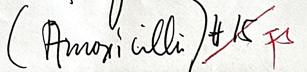

------------------------------------------------------------
[1] image_splits/training_set_splits/segmented_lines_per_image/data_101/line_2.png


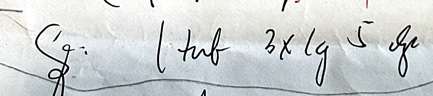

------------------------------------------------------------
[2] image_splits/training_set_splits/segmented_lines_per_image/data_101/line_3.png


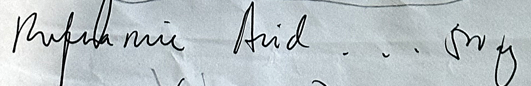

------------------------------------------------------------
[3] image_splits/training_set_splits/segmented_lines_per_image/data_101/line_4.png


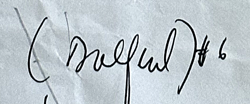

------------------------------------------------------------
[4] image_splits/training_set_splits/segmented_lines_per_image/data_101/line_5.png


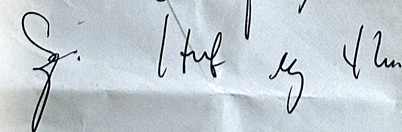

------------------------------------------------------------
[5] image_splits/training_set_splits/segmented_lines_per_image/data_101/line_6.png


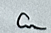

------------------------------------------------------------
[6] image_splits/training_set_splits/segmented_lines_per_image/data_102/line_0.png


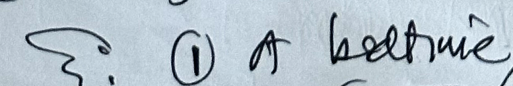

------------------------------------------------------------
[7] image_splits/training_set_splits/segmented_lines_per_image/data_102/line_1.png


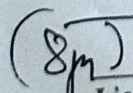

------------------------------------------------------------


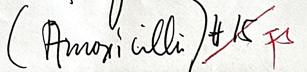

Saved: image_splits/training_set_splits/segmented_lines_per_image/data_101/line_1.png → (Amoxicilli)#15


In [43]:

from IPython.display import display

#Find unlabeled candidates
cands = df[df["transcription"].astype(str).str.len()==0].head(8).reset_index(drop=True)
print("Candidates:", len(cands))

# shows preview of the images
for i, row in cands.iterrows():
    print(f"[{i}] {row.image_path}")
    display(Image.open(row.image_path))
    print("-"*60)

# Pick which one to label
IDX = 0  # this can be changed
assert 0 <= IDX < len(cands), f"IDX out of range (0..{len(cands)-1})"
path = cands.iloc[IDX]["image_path"]
display(Image.open(path))
gt = input("Type exact transcription for this line: ").strip()

df.loc[df["image_path"] == path, "transcription"] = gt
df.to_csv(CSV_PATH, index=False)
print("Saved:", path, "→", gt)


run a tiny “smoke test” fine-tune of TrOCR using one labeled line image.

In [ ]:

labs = pd.read_csv(CSV_PATH)
labs["transcription"] = labs.get("transcription","").astype(str).fillna("")
sample = labs[labs["transcription"].str.len()>0].iloc[:1].copy()
assert len(sample)==1, "Label at least one line first."

print("Training on:", sample.iloc[0].image_path, "→", sample.iloc[0].transcription)

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

tok = processor.tokenizer
model.config.decoder_start_token_id = tok.bos_token_id
model.config.eos_token_id = tok.eos_token_id
model.config.pad_token_id = tok.pad_token_id

def preprocess_row(ex):
    img = Image.open(ex["image_path"]).convert("RGB")
    pixel_values = processor(images=img, return_tensors="pt").pixel_values.squeeze(0)
    labels = tok(ex["transcription"], return_tensors="pt",
                 padding="max_length", truncation=True, max_length=128).input_ids.squeeze(0)
    labels[labels == tok.pad_token_id] = -100
    return {"pixel_values": pixel_values, "labels": labels}

train_ds = Dataset.from_pandas(sample[["image_path","transcription"]]).map(preprocess_row)

for p in model.encoder.parameters():
    p.requires_grad = False

args = Seq2SeqTrainingArguments(
    output_dir=RUN_ONE,
    per_device_train_batch_size=1,
    num_train_epochs=1,
    learning_rate=5e-5,
    logging_steps=1,
    predict_with_generate=True,
    fp16=False,           # CPU only
    no_cuda=True,
    use_mps_device=False,
)

trainer = Seq2SeqTrainer(
    model=model, args=args,
    train_dataset=train_ds,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
)

trainer.train()
model.save_pretrained(MODEL_ONE)
processor.save_pretrained(MODEL_ONE)
print("Saved model →", MODEL_ONE)


Training on: image_splits/training_set_splits/segmented_lines_per_image/data_1/line_0.png → Loratadine 10mg/tab #5


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1/1 [00:00<00:00, 24.12 examples/s]
/Users/gabvinttongol/Desktop/Thesis/ocr-models/.venv/lib/python3.13/site-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/var/folders/2m/g_1m7h_111sc78wlzxdzh8lw0000gn/T/ipykernel_20443/2867746362.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model co

Step,Training Loss
1,9.775400


Saved model → models/trocr_one_image_cpu


Takes one labeled line image, run the trained TrOCR model to get a text prediction, then score it with WER/CER and save a tiny report.

In [23]:

processor = TrOCRProcessor.from_pretrained(MODEL_ONE)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_ONE).to("cpu")

row = sample.iloc[0]
img = Image.open(row.image_path).convert("RGB")
pv  = processor(images=img, return_tensors="pt").pixel_values

with torch.no_grad():
    pred_ids = model.generate(pv, num_beams=8, early_stopping=True, max_new_tokens=32)
pred = processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

wer_val = _wer(row.transcription, pred)
cer_val = _cer(row.transcription, pred)
print("Image:", row.image_path)
print("GT   :", row.transcription)
print("Pred :", pred)
print(f"WER  : {wer_val:.3f} | CER : {cer_val:.3f}")

pd.DataFrame([{
    "image_path": row.image_path, "gt": row.transcription,
    "pred": pred, "wer": round(wer_val,3), "cer": round(cer_val,3)
}]).to_csv(f"{RUN_ONE}/predictions.csv", index=False)
print(f"Wrote {RUN_ONE}/predictions.csv")


Image: image_splits/training_set_splits/segmented_lines_per_image/data_1/line_0.png
GT   : Loratadine 10mg/tab #5
Pred : Loratadinae tooradina
WER  : 1.000 | CER : 0.500
Wrote runs/trocr_one_image_cpu/predictions.csv


## Multiple lines 

In [45]:

try:
    from sklearn.model_selection import train_test_split
except Exception as e:
    raise SystemExit("Install scikit-learn to use this cell: pip install scikit-learn")

labs = pd.read_csv(CSV_PATH)
labs["transcription"] = labs.get("transcription","").astype(str).fillna("")
labs = labs[labs["transcription"].str.len()>0].copy()
assert len(labs) >= 8, "Please label at least 8 lines for a small train/val split."

train_df, val_df = train_test_split(labs, test_size=0.25, random_state=42)

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
tok = processor.tokenizer
model.config.decoder_start_token_id = tok.bos_token_id
model.config.eos_token_id = tok.eos_token_id
model.config.pad_token_id = tok.pad_token_id

def preprocess_row(ex):
    img = Image.open(ex["image_path"]).convert("RGB")
    pixel_values = processor(images=img, return_tensors="pt").pixel_values.squeeze(0)
    labels = tok(ex["transcription"], return_tensors="pt",
                 padding="max_length", truncation=True, max_length=128).input_ids.squeeze(0)
    labels[labels == tok.pad_token_id] = -100
    return {"pixel_values": pixel_values, "labels": labels}

def to_ds(df_):
    return Dataset.from_pandas(df_[["image_path","transcription"]]).map(preprocess_row)

train_ds, val_ds = to_ds(train_df), to_ds(val_df)


for p in model.encoder.parameters():
    p.requires_grad = False

RUN_MB   = "runs/trocr_smallbatch_cpu"
MODEL_MB = "models/trocr_smallbatch_cpu"
os.makedirs(RUN_MB, exist_ok=True); os.makedirs(MODEL_MB, exist_ok=True)

args = Seq2SeqTrainingArguments(
    output_dir=RUN_MB,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=5,
    predict_with_generate=True,
    fp16=False,
    no_cuda=True,          
    use_mps_device=False,  
)

trainer = Seq2SeqTrainer(
    model=model, args=args,
    train_dataset=train_ds, eval_dataset=val_ds,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
)


trainer.train()
model.save_pretrained(MODEL_MB); processor.save_pretrained(MODEL_MB)
print("Saved →", MODEL_MB)


recs = []
for _, r in val_df.iterrows():
    img = Image.open(r.image_path).convert("RGB")
    pv  = processor(images=img, return_tensors="pt").pixel_values
    with torch.no_grad():
        pred = processor.batch_decode(model.generate(pv, num_beams=8, early_stopping=True, max_new_tokens=32),
                                      skip_special_tokens=True)[0]
    recs.append({
        "image_path": r.image_path,
        "gt": r.transcription,
        "pred": pred,
        "wer": _wer(r.transcription, pred),
        "cer": _cer(r.transcription, pred),
    })

res = pd.DataFrame(recs)
print("VAL  WER:", round(res.wer.mean(),3), "| CER:", round(res.cer.mean(),3))
res.to_csv(f"{RUN_MB}/preds_val.csv", index=False)
print(f"Wrote {RUN_MB}/preds_val.csv")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 141/141 [00:00<00:00, 141.98 examples/s]
/Users/gabvinttongol/Desktop/Thesis/ocr-models/.venv/lib/python3.13/site-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/var/folders/2m/g_1m7h_111sc78wlzxdzh8lw0000gn/T/ipykernel_51184/437831091.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The mode

Step,Training Loss
5,5.863400
10,2.056200
15,3.424100
20,0.062900
25,0.000000
30,2.903300
35,0.000600
40,0.000000
45,0.000000
50,0.000000


Saved → models/trocr_smallbatch_cpu
VAL  WER: 0.461 | CER: 0.461
Wrote runs/trocr_smallbatch_cpu/preds_val.csv


In [10]:
import os, math, pandas as pd, torch
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

CSV_PATH  = "data/ground_truth_lines.csv"
MODEL_DIR = "models/trocr_smallbatch_cpu"      
RUN_DIR   = "runs/trocr_smallbatch_cpu"
os.makedirs(RUN_DIR, exist_ok=True)


gt = pd.read_csv(CSV_PATH, keep_default_na=False)
mask = gt["transcription"].astype(str).str.strip().ne("")
val_df = gt[mask].copy()
val_df["transcription"] = val_df["transcription"].astype(str)


try:
    processor = TrOCRProcessor.from_pretrained(MODEL_DIR)
except OSError:
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    processor.save_pretrained(MODEL_DIR)

model = VisionEncoderDecoderModel.from_pretrained(MODEL_DIR).to("cpu")
model.eval()

def _as_str(x):
    if x is None: return ""
    if isinstance(x, float) and math.isnan(x): return ""
    s = str(x)
    return "" if s.strip().lower() == "nan" else s

def _cer(ref, hyp):
    ref, hyp = _as_str(ref), _as_str(hyp)
    m, n = len(ref), len(hyp)
    if m == 0: return 0.0 if n == 0 else 1.0
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1] + (ref[i-1] != hyp[j-1]))
    return dp[m][n]/m

def _wer(ref, hyp):
    r = _as_str(ref).lower().split()
    h = _as_str(hyp).lower().split()
    m, n = len(r), len(h)
    if m == 0: return 0.0 if n == 0 else 1.0
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1] + (r[i-1] != h[j-1]))
    return dp[m][n]/m

rows = []
for _, r in val_df.iterrows():
    img = Image.open(r.image_path).convert("RGB")
    pv  = processor(images=img, return_tensors="pt").pixel_values
    with torch.no_grad():
        pred_ids = model.generate(
            pv,
            num_beams=8, early_stopping=True,
            min_new_tokens=1,     
            max_new_tokens=32,
        )
    pred = (processor.batch_decode(pred_ids, skip_special_tokens=True)[0] or "").strip()
    pred = _as_str(pred)         
    rows.append({
        "image_path": r.image_path,
        "gt": _as_str(r.transcription),
        "pred": pred,
        "wer": _wer(r.transcription, pred),
        "cer": _cer(r.transcription, pred),
    })

report = pd.DataFrame(rows).sort_values("image_path")

report["gt"]   = report["gt"].map(_as_str)
report["pred"] = report["pred"].map(_as_str)
report.to_csv(f"{RUN_DIR}/preds_val.csv", index=False, na_rep="")  

print("VAL  WER:", round(report.wer.mean(),3), "| CER:", round(report.cer.mean(),3))
print("Wrote", f"{RUN_DIR}/preds_val.csv")


for i in range(min(5, len(report))):
    print(i, "GT:", repr(report.iloc[i].gt), "| Pred:", repr(report.iloc[i].pred))


VAL  WER: 1.033 | CER: 0.942
Wrote runs/trocr_smallbatch_cpu/preds_val.csv
0 GT: <bound method Series.gt of image_path    image_splits/training_set_splits/segmented_lin...
gt                                       Loratadine 10mg/tab #5
pred                                                     nannan
wer                                                         1.0
cer                                                    0.863636
Name: 0, dtype: object> | Pred: 'nannan'
1 GT: <bound method Series.gt of image_path    image_splits/training_set_splits/segmented_lin...
gt                           Sig: 1 tab once a morning for itch
pred                                                           
wer                                                         1.0
cer                                                         1.0
Name: 1, dtype: object> | Pred: ''
2 GT: <bound method Series.gt of image_path    image_splits/training_set_splits/segmented_lin...
gt            Sig: Ipahid nang manipis sa mga 